In [1]:
from collections import defaultdict
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import classify

In [2]:
columns = defaultdict(list)
with open('GrammarandProductReviews.csv', encoding="utf8") as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        for (k,v) in row.items():
            columns[k].append(v)

# Preprocess data, get rid of reviews that don't have recommendation
features = list(columns.keys())
print(features)
data = columns["reviews.text"]
Y = columns["reviews.doRecommend"]
XY = zip(data,Y)
X, Y = [], []
for x,y in XY:
    if y == 'TRUE':
        X.append(x)
        Y.append(1)
    elif y == 'FALSE':
        X.append(x)
        Y.append(0)

# The first 90% are train data, the last 10% are test data
n = int(len(X)*.9)
XY_train = list(zip(X,Y))[:n]
XY_test = list(zip(X,Y))[n:]
data_train, y_train = [x for x, y in XY_train], [y for x, y in XY_train]
data_test, y_test = [x for x, y in XY_test], [y for x, y in XY_test]
print("Train data has %d positive reviews"%y_train.count(1))
print("Train data has %d negative reviews"%y_train.count(0))
print("Test data has %d positive reviews"%y_test.count(1))
print("Test data has %d negative reviews"%y_test.count(0))

# Testing
print("Testing CountVectorizer...")
count_vect = CountVectorizer()
count_vect.fit(data)
X_train = count_vect.transform(data_train)
X_test = count_vect.transform(data_test)
cls = classify.train_classifier(X_train, y_train)
classify.evaluate(X_test, y_test, cls, 'test')

print("Testing TfidfVectorizer...")
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data)
X_train = tfidf_vect.transform(data_train)
X_test = tfidf_vect.transform(data_test)
cls = classify.train_classifier(X_train, y_train)
classify.evaluate(X_test, y_test, cls, 'test')

['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc']
Train data has 49978 positive reviews
Train data has 4408 negative reviews
Test data has 5609 positive reviews
Test data has 434 negative reviews
Testing CountVectorizer...
  Accuracy on test  is: 0.9303326162502068
Testing TfidfVectorizer...
  Accuracy on test  is: 0.9356279993380772


0.9356279993380772

In [3]:
class_names = ['not recommend', 'recommend']
explainer = LimeTextExplainer(class_names=class_names)

In [4]:
c = make_pipeline(tfidf_vect, cls)

In [5]:
exp = explainer.explain_instance(data_test[100], c.predict_proba, num_features=6)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [6]:
exp.save_to_file('./display.html')

In [7]:
exp.as_list()

[('great', 0.015820493550489836),
 ('Great', 0.010553427855340384),
 ('movie', 0.0010204630064755346)]

In [8]:
fig = exp.as_pyplot_figure()

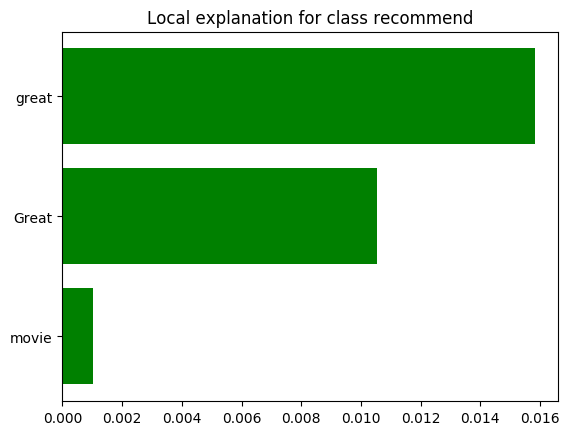

In [9]:
fig

In [10]:
import pickle

In [13]:
pickle.dump(cls, open('model1.pk', 'wb'))

In [14]:
loaded_model = pickle.load(open('model1.pk', 'rb'))

In [16]:
new_c = make_pipeline(tfidf_vect, loaded_model)
exp = explainer.explain_instance(data_test[100], new_c.predict_proba, num_features=6)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [17]:
exp.as_list()

[('great', 0.015531173742912146),
 ('Great', 0.010187965759768118),
 ('movie', 0.0009891273607359498)]

In [18]:
pickle.dump(count_vect, open('vect1.pk', 'wb'))

In [19]:
a = pickle.load(open('vect1.pk', 'rb'))

In [20]:
new_c = make_pipeline(a, loaded_model)
exp = explainer.explain_instance(data_test[100], new_c.predict_proba, num_features=6)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [21]:
exp.as_list()

[('great', 0.0015892720000784796),
 ('Great', 0.0015536315920683962),
 ('movie', 0.0008438617502344956)]